# Problem
This project is a solution to the hackathon of Kin Analytics company. The problem is to predict which customers will drop a product in less than two years based on their use of the company's products and financial data such as bank account transactions and credit bureau scores.

## Data
The data to work are four datasets with information (Data aren't in GitHub repository because the size is too big. Instead, data are in a folder on google drive.): 
1) clients: This is a historical database of clients that have purchased the product “Kin Safety” from 2012 to the delivery date.
2) clientProducts: Historical of the products the client had with the Kin Security at the moment he/she applied to the new product.
3) transactions: The transactions of clients in the pre-application moment.
4) creditScore: Bureau score of clients 6 months before and 6 months after the client applied to the new product.

In [1]:
# All packages to work in the problem
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
# Load all datasets, This process may take a while due to the download process.
clients = pd.read_csv("https://drive.google.com/uc?&confirm=no_antivirus&id=1JdAGtUh4lD4yUCDh5Og5mz8Laa1tBwFH")
clientProducts = pd.read_csv("https://drive.google.com/uc?&confirm=no_antivirus&id=1wv4xDpDEkImctyyMdZFWYlIOK4IDnUDP")
transactions = pd.read_csv("https://drive.google.com/uc?&confirm=no_antivirus&id=1ienvneTVRPXEGYK4n8OtfW_80_kySg6R")
creditScore = pd.read_csv("https://drive.google.com/uc?&confirm=no_antivirus&id=1i2YVzFXKPGzO2qQs9zNZzYws1aWLD0pS")
# To work with local files, uncomment these lines and write the local path of files:
#clients = pd.read_csv("C:/Users/DavidG/Documents/Datacfp/BASE DE DATOS/clients_table.txt")
#clientProducts = pd.read_csv("C:/Users/DavidG/Documents/Datacfp/BASE DE DATOS/products_table.txt")
#transactions = pd.read_csv("C:/Users/DavidG/Documents/Datacfp/BASE DE DATOS/transactions_table.txt")
#creditScore = pd.read_csv("C:/Users/DavidG/Documents/Datacfp/BASE DE DATOS/credit_score_table.txt")

## Desired Population
* Contracts from 2015 onwards.
* Operations in Italy were closed this year (2019).
* Take out clients with more than 75% of their info missing.
* Each client should only have one contract in the database, no more.
* A client to be eligible, it must have at least two years of information within the company (even if it canceled the product).

In [3]:
clients.head() # First, I see the general structure of the clients' dataset

,CustomerId,Surname,Geography,Gender,HasCrCard,IsActiveMember,EstimatedSalary,application_date,exit_date,birth_date
0,15745584,EIRLS,Germany,Female,0.0,1.0,0.00,2018-12-14,NaN,1997-09-18
1,14990118,MOLOCK,Italy,Male,1.0,0.0,121219.28,2019-01-08,NaN,1980-08-03
2,14733224,PAWLUCH,Italy,Female,1.0,1.0,159663.59,2012-08-01,2013-08-09,1977-08-19
3,14648573,NALLS,Spain,Male,1.0,0.0,140827.98,2019-06-19,NaN,1979-02-27
4,15365443,EBERLE,Italy,Male,1.0,0.0,35521.28,2014-01-26,2015-12-04,1972-12-21


In [4]:
n_entries = len(clients)
n_unique_clients = len(clients['CustomerId'].unique())
print(n_entries == n_unique_clients) # I check if each client has only one entry in the dataset, The result is false.
# I will try to drop duplicate entries.
print("{} entries are in excess".format(n_entries - n_unique_clients)) # This is the number of entries that I have in excess.
clients.drop_duplicates(inplace = True) # Drop duplicates entries
assert len(clients['CustomerId'].unique()) == len(clients) # Check if this process gives me the result I need. 
# It's works
print("I started with {} entries and I finished with {} unique entries". format(n_entries, n_unique_clients))

False
45000 entries are in excess
I started with 1545000 entries and I finished with 1500000 unique entries


In [5]:
clients['application_date'] = pd.to_datetime(clients['application_date']) # Then, I convert to datetime the 'application_date' column
clients = clients[(clients['application_date'] >= '2015') 
                  & (clients['application_date'] <= max(clients['application_date']) - pd.Timedelta('730d'))]
# I apply a filter with querying contracts from 2015 until the max date minus 730 days (2 years) Pandas will not support Y, M, and y values.
# It's better to use days and avoids future headaches.
print("After selecting only contracts from 2015 to 2 years before the last contract. The dataset has {} entries". format(len(clients)))

After selecting only contracts from 2015 to 2 years before the last contract. The dataset has 10000 entries


In [6]:
print(clients['Geography'].unique()) # After applying the filter, The dataset doesn't have clients from Italy. 
# For this reason, It isn't necessary to apply a filter for Italy´s clients.
print(clients.apply(lambda x: np.sum(x.isna()), axis = 0)) # In this step, I check the clients who have lost information. 
# Only in exit_date appears missing data.
# For this reason, I don't need to apply a filter to leave clients with 25% or more information.
print("The final number of clients after filtering is {}". format(len(clients)))

['Germany' 'France' 'Spain']
CustomerId             0
Surname                0
Geography              0
Gender                 0
HasCrCard              0
IsActiveMember         0
EstimatedSalary        0
application_date       0
exit_date           2817
birth_date             0
dtype: int64
The final number of clients after filtering is 10000


In [7]:
clients['birth_date'] = pd.to_datetime(clients['birth_date']) # Then, I convert to datetime the 'birth_date' column
# And I create the column age at the moment of application.
clients['Age'] = (clients['application_date'] - clients['birth_date']).astype('timedelta64[Y]') 
clients.reset_index(drop = True, inplace = True) # Finally I reset the index
# The clients' dataset is ready to use.

## Products dataset
This dataset is used to get the number of products per client at the moment of application.

In [8]:
print(np.sum(clientProducts.duplicated())) # First, I check if the clientProducts dataset has duplicate entries. 
# The result is 0, There aren't duplicate entries.
# Then, I create a new dataset with the number of products of each client. I use groupby and agg to make it optimized.
products = clientProducts.groupby('CustomerId').agg({'Products': len}) 
clients = pd.merge(clients, products, how='left', on='CustomerId') # Finally, I merge the clients' dataset with the product dataset.

0


## Transactions dataset
This dataset is used to get the balance in the bank account at the moment of application.

In [9]:
# First, I check if the columns' types are correct to manipulate it. The 'Value' column is float, It's correct to get the balance.
print(transactions.dtypes)
# I check if the transaction dataset has duplicate entries. The result is 0, There aren't duplicate entries.
print(np.sum(transactions.duplicated()))
balance = transactions.groupby('CustomerId').agg({'Value': np.sum}) # Then, I create a new dataset with the value in the clients' accounts. 
# I use groupby and agg to make it optimized.
clients = pd.merge(clients, balance, how='left', on='CustomerId') # I merge the clients' dataset with the balance dataset.
clients.rename(columns = {'Value': 'Balance'}, inplace = True) # I rename the 'Value' column to a more explicit name
clients['Balance'] = clients.apply(lambda x: 0 if abs(x['Balance']) < 0.01 else x['Balance'], axis = 1) # Finally, I convert small numbers in 0

CustomerId       int64
Transaction     object
Value          float64
dtype: object
0


## Credit bureau scores
This dataset is used to get the score of the credit bureau at the moment of application.

In [10]:
creditScore['Date'] = pd.to_datetime(creditScore['Date']) # First, I convert 'Date' column to datetime format
# To search the credit score at the moment of application, I create the function 'get_score' to apply each row of clients' dataset
def get_score(row):
    client_scores = creditScore[creditScore['CustomerId'] == row['CustomerId']] # In the function, first I get the data of the client who I need
    try:
    # Then, I try to get the score with the comparison of the date of application and the date in credit data client
    # I considered that the credit score for each month It is calculated at its start.
        score = client_scores[client_scores['Date'].dt.to_period('M') == row['application_date'].to_period('M')]['Score']
        return int(score)
    except:
    # If I don't find the value, I return NaN value
        return np.NaN

clients['Score'] = clients.apply(get_score, axis = 1) # I apply the function. Always Apply is better than a for loop ;)
print(np.sum(clients['Score'].isna())) # I check if the apply function doesn't find a value, The result is 0, all values are found.

0


# Statistics variables
In this section, I find the mean, standard deviation, maximum, and minimum of the age, products, balance, and score.

In [11]:
# Then, I select only columns that I need and find statistics variables with agg function.
clients[['Age', 'Products', 'Balance', 'Score']].agg({'Age': [np.mean, np.std, np.max, np.min], 
                                                      'Products': [np.mean, np.std, np.max, np.min],
                                                      'Balance': [np.mean, np.std, np.max, np.min],
                                                      'Score': [np.mean, np.std, np.max, np.min]})

,Age,Products,Balance,Score
mean,38.921800,1.530200,76485.889288,650.528800
std,10.487806,0.581654,62397.405202,96.653299
amax,92.000000,4.000000,250898.090000,850.000000
amin,18.000000,1.000000,0.000000,350.000000


# Solution
In this section, I build a predictive statistical to predict the probability of a client dropping/canceling the product within 2 years.

## Last preparation data
In order to complete the objective (It may change in different sceneries). I need to prepare the data for this specific goal.

In [12]:
clients['exit_date'] = pd.to_datetime(clients['exit_date']) # First, I converted the 'exit_date' column to datetime format.
clients['service_days'] = clients['exit_date'] - clients['application_date'] # Then, I calculated the number of days with the service.
# Create a column to make the gender in numerical variable.
clients['Gender_label'] = clients.apply(lambda x: 1 if x['Gender'] == 'Male' else 0, axis = 1) 

## Working with missing values
It's time to make the variable to predict and decide what I do with missing values. I did this:
1) The new variable will be 'drop_product', It has 1 if the client dropped the product before 2 years (< 730 days).
2) The dataset only has missing values in 'exit_date' column. It would mean the client doesn't leave the product or It's an error in registration. In this case, I assign 1 if the client isn't active and assume that the client has the product if they are active.

In [13]:
# At this point, I consider it's necessary to create a copy of the dataset. In case I fail with my hypothesis of missing values.
clients_copy = clients.copy()
# The missing values represent 28.17%, It's a significant percentage to only drop it.
print(100*len(clients[pd.isnull(clients['exit_date'])])/len(clients)) 
# The function 'is_drop_product' make the process detailed before.
def is_drop_product(row):
    if pd.isnull(row['service_days']):
        return int(not(row['IsActiveMember']))
    else:
        if row['service_days'] < pd.Timedelta('730d'):
            return 1
        else:
            return 0
clients['drop_product'] = clients.apply(is_drop_product, axis = 1) # Create the new column
# I select only variables that I consider relevant to the model. I ignore
data_to_work = clients[['Gender_label', 'HasCrCard', 'EstimatedSalary', 'Age', 'Products', 'Balance', 'Score', 'drop_product']]

28.17


## Exploring Data
In this section, I explore the data to search for patrons or some indicators to make a decision to select a predictive model.

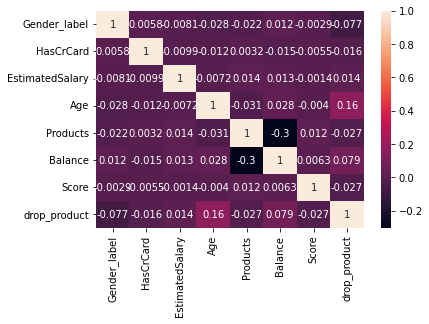

In [14]:
heatmap = sn.heatmap(data_to_work.corr(), annot = True) # First, I explore the correlation of variables.
# It isn't clear, there isn't a significant correlation between drop_product and other variables.

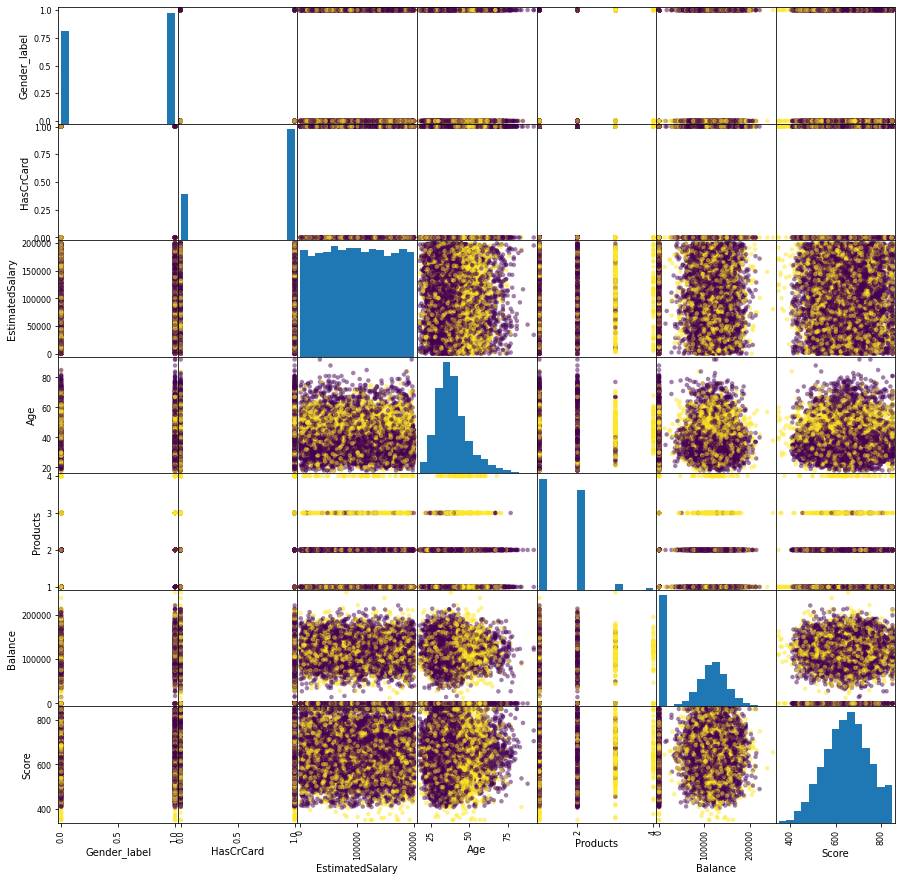

In [15]:
# I create x and y variables to plot the relation as a scatter chart.
x = data_to_work[['Gender_label', 'HasCrCard', 'EstimatedSalary', 'Age', 'Products', 'Balance', 'Score']]
y = data_to_work['drop_product']
scatter = pd.plotting.scatter_matrix(x, c= y, marker = 'o', s=20, hist_kwds={'bins':15}, figsize=(15,15))

At this point, I start to suspect my hypothesis was wrong, I try to do the same but this time I only drop the missing values.

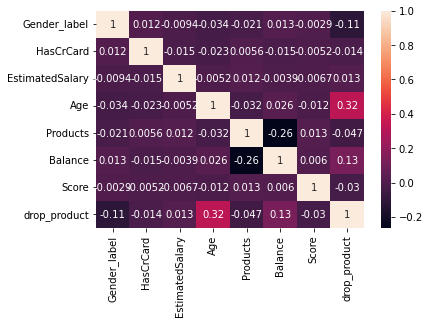

In [16]:
new_data = clients_copy[~pd.isnull(clients['exit_date'])].copy()
new_data['drop_product'] = new_data.apply(is_drop_product, axis = 1) # Create the new column
# I select only variables that I consider relevant to the model. I ignore
new_data_to_work = new_data[['Gender_label', 'HasCrCard', 'EstimatedSalary', 'Age', 'Products', 'Balance', 'Score', 'drop_product']]
heatmap = sn.heatmap(new_data_to_work.corr(), annot = True) # First, I explore the correlation of variables.
# In this case, the variables are more correlated with 'drop_product' variable.

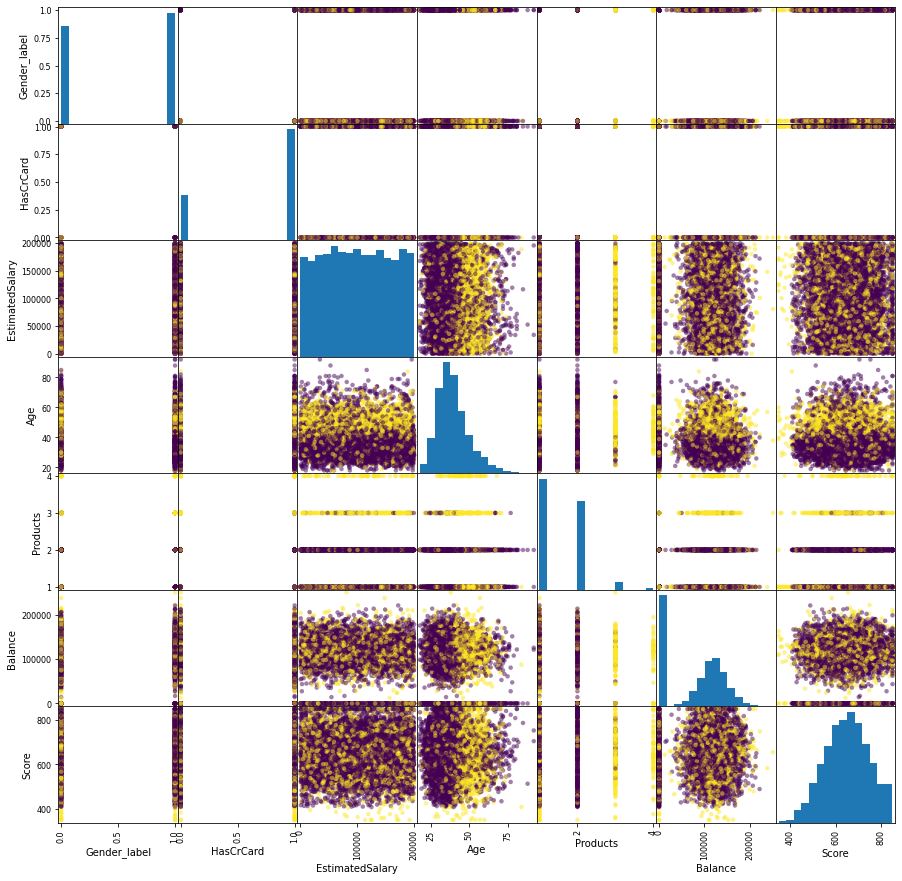

In [17]:
# I create x and y variables to plot the relation as a scatter chart.
x = new_data_to_work[['Gender_label', 'HasCrCard', 'EstimatedSalary', 'Age', 'Products', 'Balance', 'Score']]
y = new_data_to_work['drop_product']
scatter = pd.plotting.scatter_matrix(x, c= y, marker = 'o', s=20, hist_kwds={'bins':15}, figsize=(15,15))
# The chart is more clear, and different zones appear. I will continue in this way.

## Building prediction model
In this section, I explore the possible solutions and select one. It's clear that I need a binary classification model.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0) # First, I create my datasets to train and test.
# I conserve 75% to train and 25% to test (Default values)
sc = StandardScaler() # Create a standardscaler object
x_train = sc.fit_transform(x_train.values) # I normalize the data to train
x_test = sc.transform(x_test.values) # Normalize the test data
# y's data doesn't need to be normalized because it only has 0 and 1 possible values.

In [19]:
# I explore 7 classifires to search the best to this task.
# In a process that it doesn't show I explored different parameters for each classifier to search for the best result.

# K Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors = 10).fit(x_train, y_train)
print("The accuracy of K Neighbors Classifier is {}".format(knn.score(x_test, y_test)))

#  Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)
print("The accuracy of Decision Tree Classifier is {}".format(dtc.score(x_test, y_test)))

# Logistic Regression
logreg = LogisticRegression().fit(x_train, y_train)
print("The accuracy of Logistic Regression is {}".format(logreg.score(x_test, y_test)))

# Support Vector Classifier, poly kernel
svcpoly = SVC(kernel='poly', degree = 3).fit(x_train,y_train)
print("The accuracy of Support Vector Classifier, poly kernel is {}".format(svcpoly.score(x_test, y_test))) 

# Support Vector Classifier, rbf kernel
svcrbf = SVC(kernel = 'rbf', gamma=0.1).fit(x_train, y_train)
print("The accuracy of Support Vector Classifier, rbf kernel is {}".format(svcrbf.score(x_test, y_test))) 

# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 0).fit(x_train, y_train)
print("The accuracy of Random Forest Classifier is {}".format(rfc.score(x_test, y_test))) 

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state = 0, learning_rate=0.2).fit(x_train, y_train)
print("The accuracy of Gradient Boosting Classifier is {}".format(gbc.score(x_test, y_test))) 

The accuracy of K Neighbors Classifier is 0.7583518930957683
The accuracy of Decision Tree Classifier is 0.7739420935412027
The accuracy of Logistic Regression is 0.705456570155902
The accuracy of Support Vector Classifier, poly kernel is 0.767260579064588
The accuracy of Support Vector Classifier, rbf kernel is 0.7711581291759465
The accuracy of Random Forest Classifier is 0.7834075723830735
The accuracy of Gradient Boosting Classifier is 0.7906458797327395


The results show the best classifiers are Random Forest Classifier and Gradient Boosting Classifier, I select both to evaluate.

# Evaluation
To evaluate both models selected in the last section, I will do:
1) Compare with a baseline model
2) Run a cross-validation
3) Make a prediction and generate the confusion matrix

## Compare with a baseline model
The baseline model to compare is the Dummy Classifier of sklearn package with 'most_frecuent' strategy

In [20]:
dc = DummyClassifier(strategy = 'most_frequent').fit(x_train, y_train) # Dummy Classifier
dc_score = dc.score(x_test, y_test) # Get accuracy of dummy Classifier
rfc_score = rfc.score(x_test, y_test) # Get accuracy of Random Forest Classifier
gbc_score = gbc.score(x_test, y_test) # Get accuracy of Gradient Boosting Classifier
print("The accuracy of Random Forest Classifier is {}% better than Dummy Classifier"
      .format(100*(rfc_score - dc_score)))
print("The accuracy of Gradient Boosting Classifier is {}% better than Dummy Classifier"
      .format(100*(gbc_score - dc_score)))

The accuracy of Random Forest Classifier is 8.797327394209354% better than Dummy Classifier
The accuracy of Gradient Boosting Classifier is 9.521158129175955% better than Dummy Classifier


## Cross-validation 
It's important to verify if the models don't have overfitting. Running a cross-validation test is very useful to do this.

In [21]:
# It's necessary to concatenate the train and test data to use all information.
rfc_scores = cross_val_score(rfc, np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))
gbc_scores = cross_val_score(gbc, np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))
print("The scores of rfc are:")
print(rfc_scores)
print("The scores of bgc are:")
print(gbc_scores)

The scores of rfc are:
[0.81141267 0.79749478 0.77592206 0.79456825 0.78969359]
The scores of bgc are:
[0.80793319 0.80862909 0.80167015 0.79108635 0.79735376]


In [22]:
# To choose one of the models I check their means and standard deviations
print("RFC mean is: {}, and std is: {}".format(np.mean(rfc_scores), np.std(rfc_scores)))
print("GBC mean is: {}, and std is: {}".format(np.mean(gbc_scores), np.std(gbc_scores)))

RFC mean is: 0.7938182688710425, and std is: 0.011497210400720879
GBC mean is: 0.801334508018291, and std is: 0.006599049754715169


With a little advantage, the winning model is Gradient Boosting Classifier

## Confusion matrix
Finally, I check the behavior of the model with a matrix confusion

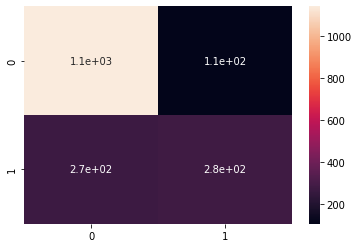

In [23]:
y_pred = gbc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
heatmap = sn.heatmap(cm, annot = True)

# Conclusion
The best model found was made with a Gradient Boosting Classifier. It has sense because we have a complex task to binary classify. Something interesting is the model has more false-positive rates than false-negative rates. In a commercial context, It isn't very bad. It's better to get focus on clients who we think will leave our product although this doesn't happen.